
Overview
Time series models are used in a wide range of applications, particularly for forecasting.

This notebook contains lab material for familarizing with key aspects of time series analysis. Here, we will perform analyses on a time series of California dairy data. Specifically, we will explore the structure of the time series and forecast the monthly production of fresh milk in the state of California.

This exploration is performed in four steps:

Explore the characteristics of the time series data.
Decompose the time series of monthly milk production into trend, seasonal components, and remainder components.
Apply time series models to the remainder component of the time series.
Forecast the production of monthly milk production for a 12 month period.

# Load and Examine the Data

As a first step, read the data from the csv file and load it into a dataframe.

In [ ]:
!conda install -m rpy2

In [1]:

# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# define the file path and read the csv file into a dataframe
file = r"C:\Users\ashukla\Documents\DS\cadairydata.csv"
df = pd.read_csv(file,encoding="ISO-8859-1")
df.head()

,Unnamed: 0,Year.Month,Month.Number,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price
0,1,1995.01,1,1995,Jan,4.370,51.595,2.112,0.9803
1,2,1995.02,2,1995,Feb,3.695,56.086,1.932,0.8924
2,3,1995.03,3,1995,Mar,4.538,68.453,2.162,0.8924
3,4,1995.04,4,1995,Apr,4.280,65.722,2.130,0.8967
4,5,1995.05,5,1995,May,4.470,73.730,2.227,0.8967


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 9 columns):
Unnamed: 0           228 non-null int64
Year.Month           228 non-null float64
Month.Number         228 non-null int64
Year                 228 non-null int64
Month                228 non-null object
Cotagecheese.Prod    228 non-null float64
Icecream.Prod        228 non-null float64
Milk.Prod            228 non-null float64
N.CA.Fat.Price       228 non-null float64
dtypes: float64(5), int64(3), object(1)
memory usage: 16.1+ KB


In [4]:
df['Month'] = df['Month'].str[:3]

df = df.rename(columns={"Month.Number":"Month","Month":"Month.Name"})
df['Day'] = pd.Series(['01']*len(df))
df['Date'] =pd.to_datetime(df[["Year","Month","Day"]])

df = df.drop(["Unnamed: 0","Year.Month","Cotagecheese.Prod","Icecream.Prod","N.CA.Fat.Price","Day"],
             axis=1)

df.head()

,Month,Year,Month.Name,Milk.Prod,Date
0,1,1995,Jan,2.112,1995-01-01
1,2,1995,Feb,1.932,1995-02-01
2,3,1995,Mar,2.162,1995-03-01
3,4,1995,Apr,2.130,1995-04-01
4,5,1995,May,2.227,1995-05-01


Text(0.5, 1.0, 'Milk Production in California')

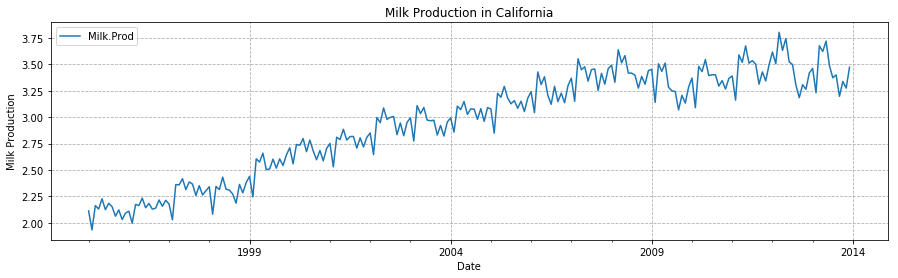

In [5]:

fig = plt.figure(figsize=(15,4))
ax = fig.gca()
df.plot(x="Date",y="Milk.Prod",ax=ax)
ax.grid(linestyle='--')
ax.set_xlabel("Date")
ax.set_ylabel("Milk Production")
ax.set_title("Milk Production in California")


For most of the time period shown, the production of milk increased year over year. However, there is a decline in milk production starting in 2009 as a results of the recession. Also, notice that this time series exhibits a strong seasonal component with an annual cycle.

# Statistical Properties of the Time Series
Having examined the time series of milk production, we will now explore some statistical properties of the time series. Autocorrelation is a fundamental property of time series. The Autocorrelation Function or ACF provides information on the dependency of the time series values of previous values. Later in this project, we will use the results of a ACF analysis to estimate the order of moving average processes. The Partial autocorrelation Function or PACF, measures the correlation of the time series with its own lag values. Later in this project, we will use an PACF to estimate the order of an autoregressive process. Execute the code in the following cell and examine the ACF and PACF of the milk production time series.

In [6]:

# import plot_acf, plot_pacf from statsmodel library
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# define a function to plot the autocorrelation for the CA milk production
def acfPlot(x):
    fig = plt.figure(figsize=(15,4))
    fig.clf()
    ax = fig.gca()
    plot_acf(x=x,ax=ax,lags=20)
    
# define a function to plot the partial autocorrelation for the CA milk production
def pacfPlot(x):
    fig = plt.figure(figsize=(15,4))
    fig.clf()
    ax = fig.gca()
    plot_pacf(x=x,ax=ax,lags=20)

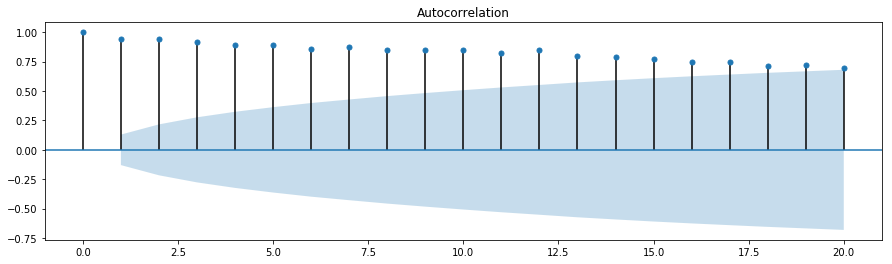

In [7]:

# plot acf
acfPlot(x=df["Milk.Prod"])

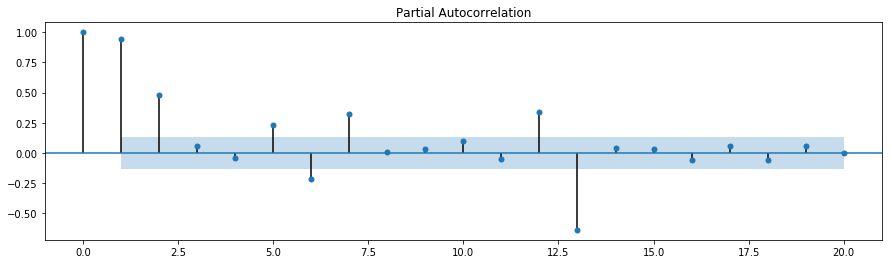

In [8]:
# plot pacf
pacfPlot(x=df['Milk.Prod'])

Note that the values of the ACF at the various lags decays only slowly. This indicates there is considerable serial correlation between the time series values at the various lags, mostly likely from the trend.
Plotting a histogram provides information on the distribution of values of the time series. Execute the code in the cell below and examine the histogram.

In [9]:
# define a function to plot histogram of the time series
def hist_ts(series):
    fig = plt.figure(figsize=(12, 4))
    fig.clf()
    ax = fig.gca()
    series.hist(bins = 40, ax = ax)
    return 'Done'

# define a function to plot box plot of the time series
def dairy_box(df, col, by):
    fig = plt.figure(figsize=(12, 4))
    fig.clf()
    ax = fig.gca()
    df.boxplot(column = col, by = by, ax = ax)
#     ax.set_xlabel(col)
#         ax.set_ylabel('Arival Delay in minutes')
#         ax.set_title('Arival Delay by ' + col)
    return 'Done'

'Done'

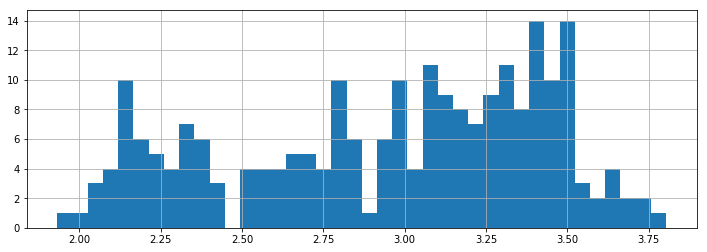

In [10]:
# plot histogram of 'Milk Production' time series
hist_ts(series=df['Milk.Prod'])

# Simple Moving Average Decomposition of the Time Series
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components. Systematic: Components of the time series that have consistency or recurrence and can be described and modeled. Non-Systematic: Components of the time series that cannot be directly modeled. A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. These components are defined as follows: Level: The average value in the series. Trend: The increasing or decreasing value in the series. Seasonality: The repeating short-term cycle in the series. Noise/Residual: The random variation in the series.

Time Series Components
A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonality components are optional. It is helpful to think of the components as combining either additively or multiplicatively. An additive model suggests that the components are added together as follows: y(t) = Level + Trend + Seasonality + Noise. An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles). A multiplicative model suggests that the components are multiplied together as follows: y(t) = Level x Trend x Seasonality x Noise. A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line. A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

The code in the cell below uses moving window method to compute the average of the time series over specified span - a period of 12 months here. As the moving window operator moves over the data, the average of the values in the windows is calculated. Execute the cell to load the function.

In [11]:

# function to calculate the simple moving average
def moving_avg(df,col,order):
    arr = []
    total = 0
    avg = 0
    for i in range(len(df)):
        if (i-order+1) < 0:
            df.at[i,'Moving_Average'] = 0
        else:
            if (i-order+1) == 0:
                j = 0
            else:
                j = j+1
            total = df.loc[j:i,col].sum()
            avg = total/(i-j+1)
            arr.append(avg)
            df.at[i,'Moving_Average'] = avg
            avg = 0
            total = 0
    plt.plot(df['Moving_Average'][12:])

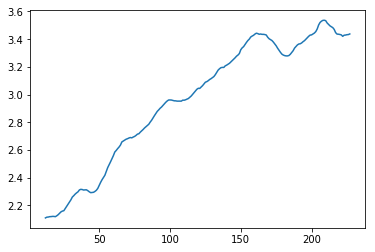

In [12]:

moving_avg(df, col = 'Milk.Prod', order = 12)

Alternatively, we can also use the 'rolling' function of pandas to calculate the simple moving average

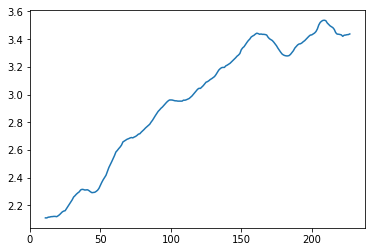

In [13]:
xx = df['Milk.Prod'].rolling(12).mean()
plt.plot(xx)

# Automatic Time Series Decomposition
There are methods to automatically decompose a time series. The statsmodels library provides an implementation of the naive, or classical decomposition method in a function called seasonal_decompose(). It requires that we specify whether the model is additive or multiplicative.

For our problem, we will use the statsmodel library to decompose the time series into its components. The code in the cell below uses multiplicative decomposition of the time series. The moving average is computed over a twelve month moving window.

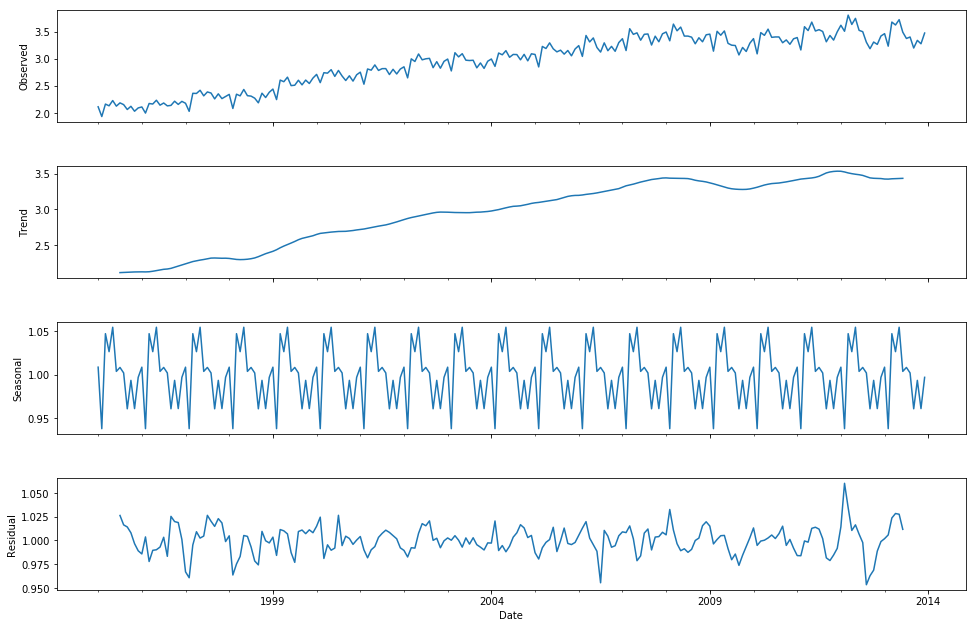

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

def naive_decompose(df,col,model):
    result = seasonal_decompose(df[col], model=model)
    result.plot()

    fig = plt.gcf()
    ax = fig.gca()
    fig.set_size_inches(15,10)
    
    return result

df_new = df.set_index(['Date']) # seasonal_decompose requires a datetime index
na = naive_decompose(df=df_new,col='Milk.Prod',model='multiplicative')


It can be seen that the trend and seasonal components are clearly separated in the above plots. The remainder plot looks fairly random, as expected. But, is the remainder actually stationary? To test for stationarity of the remainder, plot the ACF.

In [15]:
df_new["residual_naiveDecomp"] = na.resid

df_new.dropna(axis=0,inplace=True) # drop NaN values in the residual
# df_new.isnull().sum()

df_new.head()

,Month,Year,Month.Name,Milk.Prod,Moving_Average,residual_naiveDecomp
Date,,,,,,
1995-07-01,7,1995,Jul,2.184,0.0,1.026405
1995-08-01,8,1995,Aug,2.152,0.0,1.016488
1995-09-01,9,1995,Sep,2.062,0.0,1.014267
1995-10-01,10,1995,Oct,2.121,0.0,1.008108
1995-11-01,11,1995,Nov,2.030,0.0,0.996652


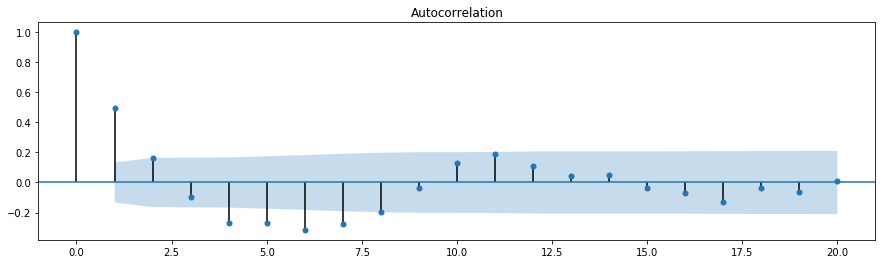

In [16]:
acfPlot(x=df_new["residual_naiveDecomp"])

'Done'

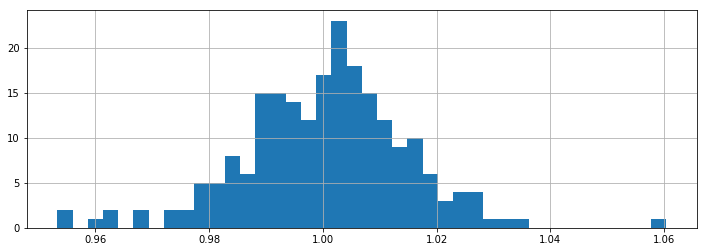

In [17]:

hist_ts(series=df_new["residual_naiveDecomp"])

'Done'

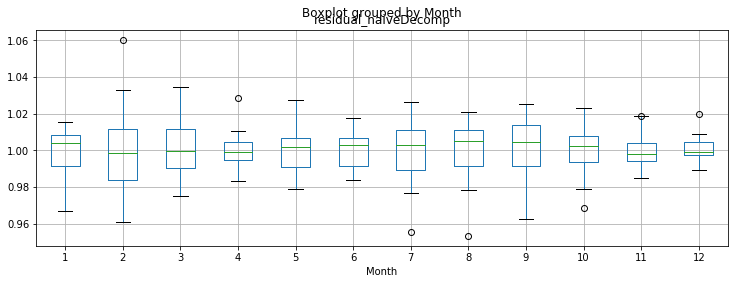

In [18]:
dairy_box(df_new,col='residual_naiveDecomp' , by='Month')

# Exploring the Multiplicative Model with lowess
Having tried a simple moving average decomposition, you will now use a lowess model to determine the trend. Lowess is a sophisticated non-linear regression. The lowess trend model is combined with a moving window seasonal component model into the R stl function. The code in the cell below uses stl to decompose a time series. Pandas has a package named rpy2 which enables us to use R's robust statistical decomposition with loess, but in python! A new dataframe is created with components of the time series decomposition. Plots are created of the components of the time series.

In [ ]:
!conda install -m rpy2

In [ ]:
# import dependencies
import rpy2
import pandas.rpy.common
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr

In [ ]:
#  define a function to decompose the time series into its components using Loess
def decompose(df, col, span, frequency, Mult, s_window = 'periodic'):
#     df_stl = pd.DataFrame()
#     df_stl['date'] = df.index
    if Mult:
        series = df[col].pipe(np.log)
    else:
        series = df[col]
    s = [x for x in series.values]
    length = len(series)
    span = span*length
    s = r.ts(s, frequency=frequency,start=1)
    decomposed = [x for x in r.stl(s, s_window,t_window=span).rx2('time.series')]
    df['observed_stl'] = series.values
    df['trend_stl'] = decomposed[length:2*length]
    df['seasonal_stl'] = decomposed[0:length]
    df['residual_stl'] = decomposed[2*length:3*length]
    return df

In [ ]:
df_stl = decompose(df=df_new,col='Milk.Prod',span=0.5, frequency=12, Mult=False)
df_stl.head()

In [ ]:

# define a function to create the plots of time series components
def plot_components(df,observed,trend,seasonal,residual):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(figsize=(15,12),ncols=1,nrows=4,sharex=True)
    
    df.plot(y=observed,use_index=True, ax=ax1, label='Observed')
    df.plot(y=trend,use_index=True, ax=ax2, label='Trend')
    df.plot(y=seasonal,use_index=True, ax=ax3, label='Seasonal')
    df.plot(y=residual,use_index=True, ax=ax4, label='Residual')

In [ ]:

plot_components(df_stl,'observed_stl','trend_stl','seasonal_stl','residual_stl')
fig.suptitle('STL Decomposition (LOESS)')

In [ ]:
hist_ts(series=df_stl["residual_stl"])

In [ ]:
dairy_box(df_stl,col='residual_stl' , by='Month')

# Moving Average Models
Now that we have explored the decomposition of the time series, we will now construct and test Autoregressive Moving Average (ARMA) models for the remainder of the time series. We will create and test these models in three steps, creating a moving average (MA) model, creating an autoregressive (AR) model and creating an autoregressive moving average (ARMA) model. The function in the cell below computes an Autoregressive Integrative Moving Average (ARIMA) model. The summary statistics for the model are printed and the model object returned. By assigning values to the order of each operator, different time series models can be specified, as order of MA model, order of Integrative model, and order of AR model. The ACF of the remainder from the stl decomposition of the milk production time series had 5 significant lag values. As an inital model, we will now create an MA model of order 5. Execute the code in the cell below to compute the MA(5) model and examine the model summary.

In [ ]:

from statsmodels.tsa.arima_model import ARIMA

def arima_model(df,col,order):
    # fit model
    model = ARIMA(df[col], order=order)
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    
    # plot the residual
    residual_arima_df = pd.DataFrame(model_fit.resid,columns=['residual_arima'])
    fig,(ax1,ax2) = plt.subplots(figsize=(15,6),ncols=1,nrows=2,sharex=False)
    residual_arima_df.plot(kind='line',ax=ax1)
    residual_arima_df.plot(kind='kde',ax=ax2) # kde stands for Kernel Density Estimation plot
    return residual_arima_df

res_ma = arima_model(df=df_stl,col='residual_stl',order=(0,0,5))

In [ ]:
df_stl = decompose(df=df_new,col='Milk.Prod',span=0.5, frequency=12, Mult=False)
df_stl.head()

In [ ]:
# define a function to create the plots of time series components
def plot_components(df,observed,trend,seasonal,residual):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(figsize=(15,12),ncols=1,nrows=4,sharex=True)
    
    df.plot(y=observed,use_index=True, ax=ax1, label='Observed')
    df.plot(y=trend,use_index=True, ax=ax2, label='Trend')
    df.plot(y=seasonal,use_index=True, ax=ax3, label='Seasonal')
    df.plot(y=residual,use_index=True, ax=ax4, label='Residual')

In [ ]:
plot_components(df_stl,'observed_stl','trend_stl','seasonal_stl','residual_stl')
fig.suptitle('STL Decomposition (LOESS)')

The time series charts show the original time series along with the components of the decomposition. The trend is a bit smoother than was obtained with the simple moving average decomposition. The question remains, is the remainder from this decomposition stationary? To find out, plot the ACF.

In [ ]:
acfPlot(x=df_stl['residual_stl'])

In [ ]:
hist_ts(series=df_stl["residual_stl"])


In [ ]:
dairy_box(df_stl,col='residual_stl' , by='Month')

# Moving Average Models


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

def arima_model(df,col,order):
    # fit model
    model = ARIMA(df[col], order=order)
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    
    # plot the residual
    residual_arima_df = pd.DataFrame(model_fit.resid,columns=['residual_arima'])
    fig,(ax1,ax2) = plt.subplots(figsize=(15,6),ncols=1,nrows=2,sharex=False)
    residual_arima_df.plot(kind='line',ax=ax1)
    residual_arima_df.plot(kind='kde',ax=ax2) # kde stands for Kernel Density Estimation plot
    return residual_arima_df

res_ma = arima_model(df=df_stl,col='residual_stl',order=(0,0,5))

In [ ]:
acfPlot(x=res_ma['residual_arima'])

# Autoregressive Models

In [ ]:
res_ar2= arima_model(df=df_stl,col='residual_stl',order=(2,0,0))

In [ ]:
res_ar1 = arima_model(df=df_stl,col='residual_stl',order=(1,0,0))

In [ ]:

acfPlot(x=res_ar1['residual_arima'])

In [ ]:
pacfPlot(x=res_ar1['residual_arima'])

# Autoregressive Moving Average Models¶
We have found that both MA(5) and AR(1) models are good fits to the remainder series. We will now investigate the use of autoregressive moving average (ARMA) models on the remainder series. As a starting point we will try an ARMA(1,5) model by executing the code in the cell below.

In [ ]:
res_arma = arima_model(df=df_stl,col='residual_stl',order=(1,0,5))

In [ ]:

acfPlot(x=res_arma['residual_arima']) 
pacfPlot(x=res_arma['residual_arima'])

# Autoregressive Integrative Moving Average Model
We will now model the remainder series with an autoregressive integrative moving average (ARIMA) model. Execute the code in the cell below to compute an ARIMA(1,1,1) model.

In [ ]:
res_arima = arima_model(df=df_stl,col='residual_stl',order=(1,1,1))

In [ ]:
acfPlot(x=res_arima['residual_arima']) 
pacfPlot(x=res_arima['residual_arima'])



Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACF. These observations indicate that the ARIMA(1,1,1) model is a good fit. Compare these results to those of the MA(3) and AR(1) models, noting that they are nearly identical. The ARIMA(1,1,1) model is a good choice for these data as well.